In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# 1. Load data
df = pd.read_csv('chronic_kidney_disease.csv')
df.replace('?', np.nan, inplace=True)

# 2. Cek Kolom Target (Biar nggak KeyError lagi)
target_col = 'classification' if 'classification' in df.columns else 'class'
print(f"Target yang ditemukan: {target_col}")

# 3. Mapping
map_data = {"yes": 1, "no": 0, "normal": 1, "abnormal": 0, "present": 1, "notpresent": 0, "good": 1, "poor": 0, "ckd": 1, "notckd": 0}

for col in df.select_dtypes(include=['object']).columns:
    # Gunakan .str.strip() untuk hapus spasi tak terlihat di nama data
    df[col] = df[col].astype(str).str.strip().str.lower().map(map_data)

# 4. Imputasi
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(df.median())

# 5. Filter kolom_fitur (Hanya ambil yang ada di file CSV saja)
kolom_fitur_ingin = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 
                     'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 
                     'dm', 'cad', 'appet', 'pe', 'ane']

kolom_fitur_ada = [c for c in kolom_fitur_ingin if c in df.columns]

X = df[kolom_fitur_ada]
y = df[target_col]

# 6. Split & Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Berhasil! Data siap diumpankan ke model_lr.")

Target yang ditemukan: class
Berhasil! Data siap diumpankan ke model_lr.


In [3]:
# Inisialisasi model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Training
lr_model.fit(X_train_scaled, y_train)

# Prediksi untuk evaluasi
y_pred_lr = lr_model.predict(X_test_scaled)

In [4]:
# Cetak skor
print(f"Akurasi Logistic Regression: {accuracy_score(y_test, y_pred_lr):.2%}")
print("\nLaporan Klasifikasi:\n", classification_report(y_test, y_pred_lr))

# EXPORT KE PKL
with open('model_lr.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
    
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Berhasil menyimpan model_lr.pkl dan scaler.pkl!")

Akurasi Logistic Regression: 98.75%

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.98      0.99        50

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

Berhasil menyimpan model_lr.pkl dan scaler.pkl!


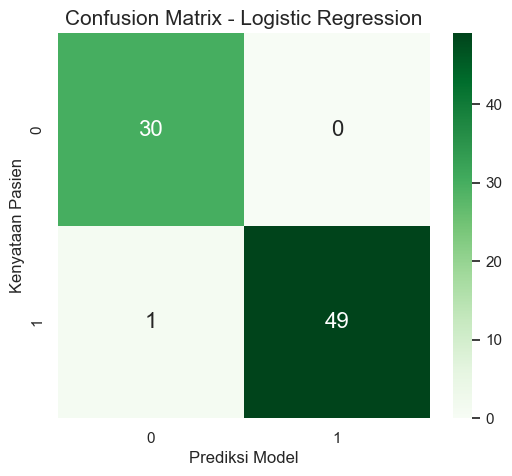

C:\Users\asus\AppData\Local\Temp\ipykernel_1172\2985157088.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Koefisien', y='Fitur', data=features_df, palette='vlag')


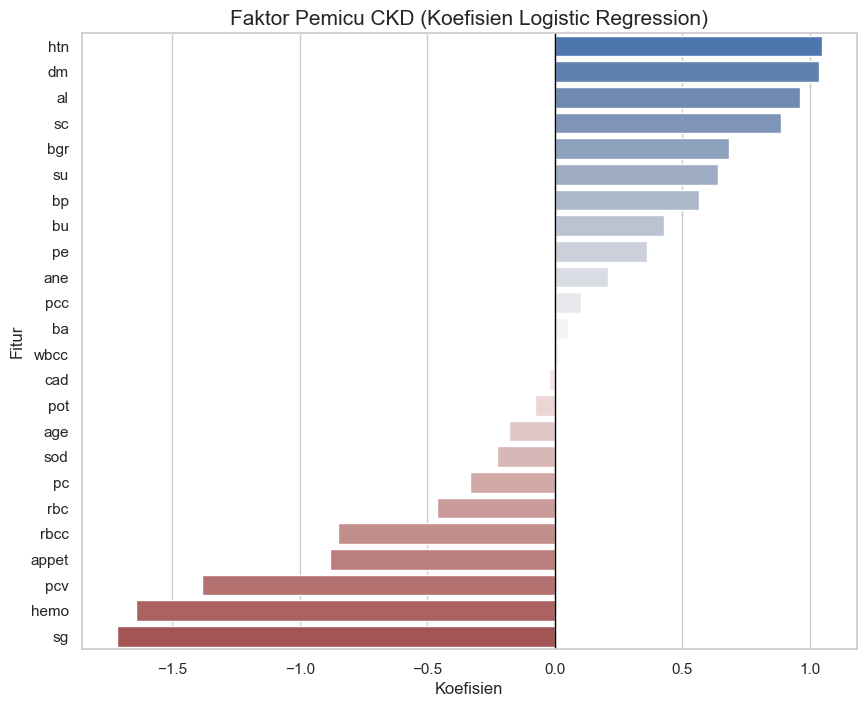

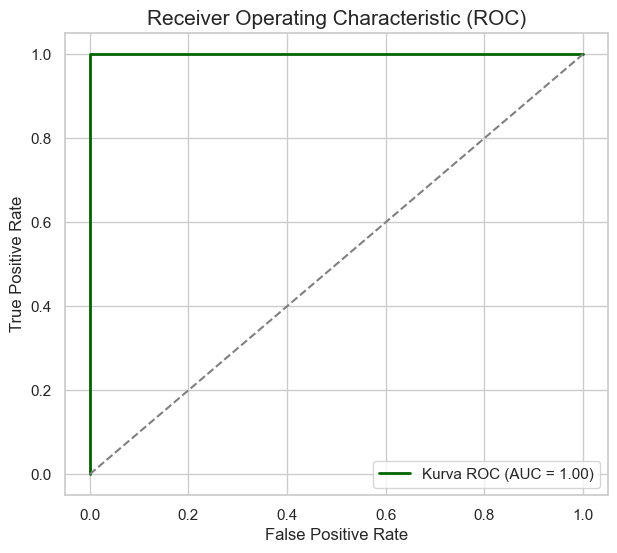

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- Pastikan tema seaborn aktif agar grafik lebih bagus ---
sns.set_theme(style="whitegrid")

# 1. CONFUSION MATRIX (Hijau untuk LR agar beda dengan XGBoost nanti)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 16})
plt.title('Confusion Matrix - Logistic Regression', fontsize=15)
plt.xlabel('Prediksi Model', fontsize=12)
plt.ylabel('Kenyataan Pasien', fontsize=12)
plt.show()



# 2. FEATURE IMPORTANCE (Ini yang sering eror kalau koefisiennya nggak pas)
# Kita ambil koefisien dari model LR
coef_values = lr_model.coef_[0]
features_df = pd.DataFrame({'Fitur': kolom_fitur_ada, 'Koefisien': coef_values})

# Urutkan dari yang paling berpengaruh
features_df = features_df.sort_values(by='Koefisien', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Koefisien', y='Fitur', data=features_df, palette='vlag')
plt.title('Faktor Pemicu CKD (Koefisien Logistic Regression)', fontsize=15)
plt.axvline(0, color='black', lw=1) # Garis tengah nol
plt.show()



# 3. ROC CURVE (Sertakan nilai AUC-nya)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'Kurva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc="lower right")
plt.show()

In [6]:
import pickle

# Menyimpan Model Logistic Regression
with open('model_lr.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Menyimpan Scaler (WAJIB, supaya angka di web dan notebook sama)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ File model_lr.pkl dan scaler.pkl berhasil diamankan!")

✅ File model_lr.pkl dan scaler.pkl berhasil diamankan!


In [8]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# 1. Pastikan prediksi sudah dilakukan
y_pred_lr = lr_model.predict(X_test_scaled)

# 2. Menghitung metrik secara detail
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# 3. Menampilkan hasil
print("\n" + "="*40)
print("    LAPORAN PERFORMA LOGISTIC REGRESSION")
print("="*40)
print(f"Akurasi   : {accuracy_lr:.2%}")
print(f"Precision : {precision_lr:.4f}")
print(f"Recall    : {recall_lr:.4f}")
print(f"F1-Score  : {f1_lr:.4f}")
print("-" * 40)
print("\nDetail Laporan Klasifikasi:")
# Menggunakan target_names agar lebih mudah dibaca (0=Sehat, 1=CKD)
print(classification_report(y_test, y_pred_lr, target_names=['Sehat', 'CKD']))
print("="*40)


    LAPORAN PERFORMA LOGISTIC REGRESSION
Akurasi   : 98.75%
Precision : 0.9879
Recall    : 0.9875
F1-Score  : 0.9875
----------------------------------------

Detail Laporan Klasifikasi:
              precision    recall  f1-score   support

       Sehat       0.97      1.00      0.98        30
         CKD       1.00      0.98      0.99        50

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

